In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import timeit
import requests

from lxml import html
from bs4 import BeautifulSoup
import re
import urllib
from bs4 import BeautifulSoup, element
os.chdir('monthly_twitch')

# Get file names from monthly twitch top 25 game metrics from Sully Gnome
# files follow a naming convention to automatically sort them by month
monthly_files = []
for root, dirs, files in os.walk('.'):
    monthly_files.append(files)

# Create list of dataframes from each file
monthly_dfs = []
i = 0
for file in monthly_files[0]:
    df = pd.read_csv(file)
    df['file_no'] = i
    monthly_dfs.append(df)
    i+=1

# concatenate all the monthly data frames
big_df = pd.concat(monthly_dfs,axis=0,ignore_index=True)

# re-engineer the file_no column creating a dictionary
date_dict = {}
months = ['2016-01','2016-02','2016-03','2016-04','2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12',
          '2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12',
          '2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12',
          '2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12',
          '2020-01','2020-02','2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09','2020-10']

for i, j in zip(sorted(big_df.file_no.value_counts().index), months):
    date_dict[i] = j
    
# execute some clean up and map the date dictionary values to the file number
big_df.replace({'file_no':date_dict},inplace=True)
big_df.drop(['Unnamed: 0','Unnamed: 1','Unnamed: 11'],axis=1,inplace=True)
big_df.rename(columns={'file_no':'date'},inplace=True)
big_df.date = pd.to_datetime(big_df.date,format='%Y-%m')

In [2]:
# read in google trends as a proxy for interest
os.chdir('..')
os.chdir('topgames_interest_data')

# read in baseline proxy measurement for global video game interest
g_df = pd.read_excel('game_search_trend.xlsx',skiprows=2)
g_df.drop(['Unnamed: 3','Unnamed: 4','Year'],axis=1,inplace=True)
g_df.rename(columns={'Month':'date','Value':'global_game_interest'},inplace=True)
g_df.date = pd.to_datetime(g_df.date,format='%Y-%m')

# read in data and transform to datetime index and stack it by games
tg_df = pd.read_excel('topgames.xlsx')
tg_df.rename(columns={'Month':'date'},inplace=True)
tg_df.date = pd.to_datetime(tg_df['date'],format='%Y-%m')
tg_df = tg_df.set_index('date').stack()

# create new df aligned with the required format to match other df
tg_time = [i for (i,j) in tg_df.index]
tg_game = [j for (i,j) in tg_df.index]
tg_vals = tg_df.values
tg_align = pd.DataFrame({'date':tg_time,'Game':tg_game,'google_search(relative)':tg_vals})

In [4]:
def find_console_tags(soup):
    # Console tags are stored as images, so we find the image tag and record its 'alt' value as text
    consoles = list()
    for img in soup.find_all('img'):
        if 'images/consoles'in img['src']:
            # Cut file path elements from string
            console_tag = (img['src'][17:-6])
            consoles.append(img['alt'])
    return consoles


# Find the names of games from the links
def find_names_column(table_path):
    names_list = list()
    for row in table_path.xpath('.//tr'):
        for td in row.xpath('.//td'):
            if not td.find('a') is None:
                names_list.append(td.find('a').text.strip()) 
    return names_list

# Write a function that takes in a VGChartz URL and gives us all the data in their video game database
def scrape_vgchartz_videogame_db_page(url):
    
    response = requests.get(url)

    ### Check the Status
    assert(response.status_code == 200)," Website not OK " # status code = 200 => OK
    
    #Store the contents of the website under doc
    page=response.text
    soup = BeautifulSoup(page, "lxml")
    doc = html.fromstring(response.content)
    
    # Selects the table with all the data in it on HTML using xpath
    target_table_path = doc.xpath('//*[@id="generalBody"]/table')[0]

    # Find column values that won't be scraped correctly with .text option
    names_list = find_names_column(target_table_path)
    consoles = find_console_tags(soup)
    
    # Parse non-image and non-URL info from the data table to a pandas DataFrame
    row_dict={}
    df=pd.DataFrame()
    row_list= list()
    for counter,row in enumerate(target_table_path.xpath(".//tr")):
        if counter > 2: # To skip header rows
            row_list=[td.text for td in row.xpath(".//td")]
            row_dict[counter] = row_list

    df=pd.DataFrame.from_dict(row_dict).transpose()
    df.columns = ['position','game','blank','console','publisher','developer','vgchart_score',\
                 'critic_score','user_score','total_shipped','total_sales',\
                  'na_sales','pal_sales','japan_sales','other_sales',\
                  'release_date','last_update']
    
    # Correct the console and game columns using scraped values
    
    df=df.reset_index().drop(columns = ['index','blank'])
    df['console'] = consoles
    df['game'] = names_list
    return df

    # We can 'hack' the URL to display any number of results per page. I'll leave it as an argument.
def scrape_all_vg_chartz_videogame_db(results_per_page):
    df = pd.DataFrame()
    current_page = 1
    games_left = True
    while games_left:
        url = 'http://www.vgchartz.com/games/games.php?page=' + str(current_page) +\
        '&results=' + str(results_per_page) + '&name=&console=&keyword=&publisher=&genre=&order=Sales&ownership\
        =Both&boxart=Both&banner=Both&showdeleted=&region=All&goty_year=&developer=&direction\
        =DESC&showtotalsales=1&shownasales=1&showpalsales=1&showjapansales=1&showothersales=1&\
        showpublisher=1&showdeveloper=1&showreleasedate=1&showlastupdate=1&showvgchartzscore=1&\
        showcriticscore=1&showuserscore=1&showshipped=1&alphasort=&showmultiplat=No'
        new_df = scrape_vgchartz_videogame_db_page(url)
        df = df.append(new_df)

        #REMOVE LATER, TEST CONDIITON
      #  if current_page > 3:
       #     games_left = False
        print('Scraped page: ',current_page)
        if new_df.shape[0] < results_per_page:
            games_left = False
        current_page +=1
    print('Scraping done!')
    print('Total rows parsed = ', df.shape[0])
    return df.reset_index().drop(columns = 'index')

# Run the code to scrape! I did 10,000 rows per page to speed things up.
vg_df=scrape_all_vg_chartz_videogame_db(10000)

Scraped page:  1
Scraped page:  2
Scraped page:  3
Scraped page:  4
Scraped page:  5
Scraped page:  6
Scraping done!
Total rows parsed =  58805


In [5]:
vg_df.rename(columns={'game':'Game'},inplace=True)
vg_bygame = vg_df.groupby('Game').sum()

In [75]:
dirty_merged = big_df.merge(vg_bygame,on='Game',how='inner')
dirty_merged

,Game,Watch time,Stream time,Peak viewers,Peak channels,Streamers,Average viewers,Average channels,Average viewer ratio,date,...,critic_score,user_score,total_shipped,total_sales,na_sales,pal_sales,japan_sales,other_sales,release_date,last_update
0,League of Legends,5662633560,81722640,530270,2903,129172,127021,1833,69.29,2016-01-01,...,8.0 N/A,N/A N/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,27th Oct 09 27th Oct 09,23rd Nov 1823rd Nov 18
1,League of Legends,5589286320,76002900,475784,2712,117996,134035,1822,73.54,2016-02-01,...,8.0 N/A,N/A N/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,27th Oct 09 27th Oct 09,23rd Nov 1823rd Nov 18
2,League of Legends,5670870660,75841740,599114,2585,117734,127206,1701,74.77,2016-03-01,...,8.0 N/A,N/A N/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,27th Oct 09 27th Oct 09,23rd Nov 1823rd Nov 18
3,League of Legends,5303342940,73035000,553165,2945,113251,122933,1692,72.61,2016-04-01,...,8.0 N/A,N/A N/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,27th Oct 09 27th Oct 09,23rd Nov 1823rd Nov 18
4,League of Legends,4840759200,71765760,433005,2635,118593,108585,1609,67.45,2016-05-01,...,8.0 N/A,N/A N/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,27th Oct 09 27th Oct 09,23rd Nov 1823rd Nov 18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Fall Guys: Ultimate Knockout,716914800,27531960,241811,2953,108676,16081,617,26.04,2020-09-01,...,N/A N/A,N/A N/A,7.00mN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,04th Aug 20 04th Aug 20,14th Jul 2014th Jul 20
997,New World,668004060,9962280,344240,2986,17706,14984,223,67.05,2020-07-01,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,25th Aug 21,16th Dec 19
998,NBA 2K21,871698480,53630280,112997,6873,68466,20206,1243,16.25,2020-08-01,...,N/A N/A N/A N/A N/A N/A N/A,N/A N/A N/A N/A N/A N/A N/A,5.00mN/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/AN/A,N/A 10th Nov 20 04th Sep 20 12th Nov 20 04...,06th Nov 2014th Jun 2014th Jun 2014th Jun 2014...
999,FIFA 21,3667730160,63627060,474733,3830,100606,82272,1427,57.64,2020-09-01,...,N/A N/A N/A N/A N/A N/A,N/A N/A N/A N/A N/A N/A,N/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/A,N/AN/AN/AN/AN/AN/A,09th Oct 20 09th Oct 20 09th Oct 20 31st De...,19th Jun 2019th Jun 2019th Jun 2019th Jun 2019...


In [76]:
# when to start looking at
after = dt.datetime.strptime('2015-12','%Y-%m')

# join the dataframes together
all_data_wna = tg_align.merge(dirty_merged,on=['date','Game'],how='outer')
all_data_wna = all_data_wna.merge(g_df,on='date')
all_data_wna = all_data_wna.loc[(all_data_wna.date>after)]

In [77]:
import re
from collections import defaultdict

split_dates = []
releases = defaultdict(list)

for string in all_data_wna.release_date:
    new_string = re.sub(r'rd',string=string,repl='')
    new_string = re.sub(r'st',string=new_string,repl='')
    new_string = re.sub(r'nd',string=new_string,repl='')
    new_string = re.sub(r'th',string=new_string,repl='')
    list_string = re.split(r'\W\W',new_string)
    split_dates.append(list_string)
    
releases = defaultdict(list)

i = 0
for lists in split_dates:
    for item in lists:
        if item not in ['','N/A']:
            releases[i].append(dt.datetime.strptime(item,'%d %b %y'))
        elif item == 'N/A':
            releases[i].append(dt.datetime.strptime('2030','%Y'))
    i += 1
    
game_releases = [min(release) for release in releases.values()]
dirty_merged.release_date = game_releases

In [82]:
all_data_wna

,date,Game,google_search(relative),Watch time,Stream time,Peak viewers,Peak channels,Streamers,Average viewers,Average channels,...,user_score,total_shipped,total_sales,na_sales,pal_sales,japan_sales,other_sales,release_date,last_update,global_game_interest
2124,2016-01-01,League of Legends,69,5662633560,81722640,530270,2903,129172,127021,1833,...,N/A N/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,N/AN/A,27th Oct 09 27th Oct 09,23rd Nov 1823rd Nov 18,88
2125,2016-01-01,Counter-Strike Global Offensive,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88
2126,2016-01-01,Dota 2,42,2711153580,26003820,315083,1100,44074,60815,583,...,N/A N/A N/A,N/AN/AN/A,N/AN/AN/A,N/AN/AN/A,N/AN/AN/A,N/AN/AN/A,N/AN/AN/A,09th Jul 13 18th Jul 13 18th Jul 13,N/A23rd Nov 1823rd Nov 18,88
2127,2016-01-01,Hearthstone,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88
2128,2016-01-01,Call of Duty Black Ops III,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,2020-10-01,New World,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70
12445,2020-10-01,NBA 2K21,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70
12446,2020-10-01,FIFA 21,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70
12447,2020-10-01,Phasmophobia,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70


In [81]:
all_data_wna.columns

Index(['date', 'Game', 'google_search(relative)', 'Watch time', 'Stream time',
       'Peak viewers', 'Peak channels', 'Streamers', 'Average viewers',
       'Average channels', 'Average viewer ratio', 'position', 'console',
       'publisher', 'developer', 'vgchart_score', 'critic_score', 'user_score',
       'total_shipped', 'total_sales', 'na_sales', 'pal_sales', 'japan_sales',
       'other_sales', 'release_date', 'last_update', 'global_game_interest'],
      dtype='object')

In [8]:
dirty_merged.loc[(dirty_merged.date<dirty_merged.release_date)&(dirty_merged['Watch time'].isnull()),
                 ['Watch time','Stream time','Peak viewers',
                  'Peak channels','Streamers','Average viewers',
                  'Average viewer ratio']] = 0

In [9]:
cols_to_fill = ['Watch time','Stream time','Peak viewers','Peak channels',
                'Streamers','Average viewers','Average viewer ratio']

for col in cols_to_fill:
    dirty_merged[col] = dirty_merged.groupby('Game')[col].transform(lambda x: x.fillna(x.median()))

[Text(0.5, 0, 'Watch time'),
 Text(1.5, 0, 'Stream time'),
 Text(2.5, 0, 'Peak viewers'),
 Text(3.5, 0, 'Peak channels'),
 Text(4.5, 0, 'Streamers'),
 Text(5.5, 0, 'Average viewers'),
 Text(6.5, 0, 'Average viewer ratio'),
 Text(7.5, 0, 'global_game_interest')]

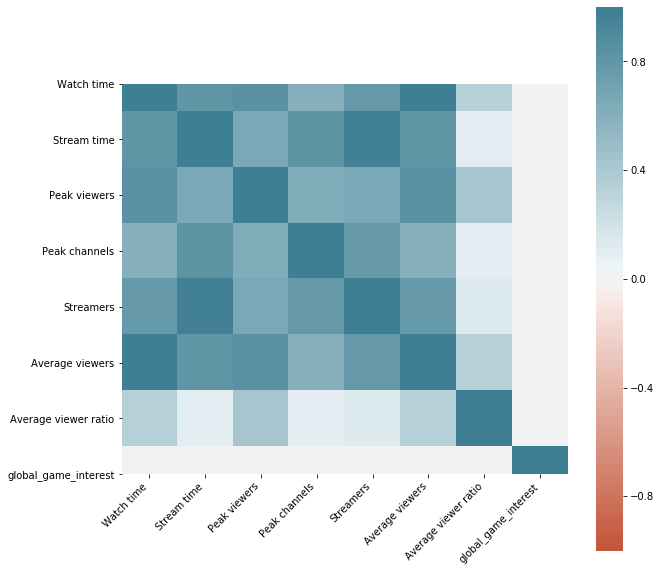

In [25]:
import seaborn as sns

corr = dirty_merged.loc[:,['google_search(relative)','Watch time','Stream time','Peak viewers',
                           'Peak channels','Streamers','Average viewers','Average viewer ratio',
                           'global_game_interest','time_since_release']].corr()

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(corr,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

In [11]:
vg_df.to_csv('vgchartz_data.csv')

In [24]:
dirty_merged.columns

Index(['date', 'Game', 'google_search(relative)', 'Watch time', 'Stream time',
       'Peak viewers', 'Peak channels', 'Streamers', 'Average viewers',
       'Average channels', 'Average viewer ratio', 'global_game_interest',
       'position', 'console', 'publisher', 'developer', 'vgchart_score',
       'critic_score', 'user_score', 'total_shipped', 'total_sales',
       'na_sales', 'pal_sales', 'japan_sales', 'other_sales', 'release_date',
       'last_update'],
      dtype='object')

[Text(0.5, 0, 'Watch time'),
 Text(1.5, 0, 'Stream time'),
 Text(2.5, 0, 'Peak viewers'),
 Text(3.5, 0, 'Peak channels'),
 Text(4.5, 0, 'Streamers'),
 Text(5.5, 0, 'Average viewers'),
 Text(6.5, 0, 'Average viewer ratio'),
 Text(7.5, 0, 'global_game_interest'),
 Text(8.5, 0, 'time_since_release')]

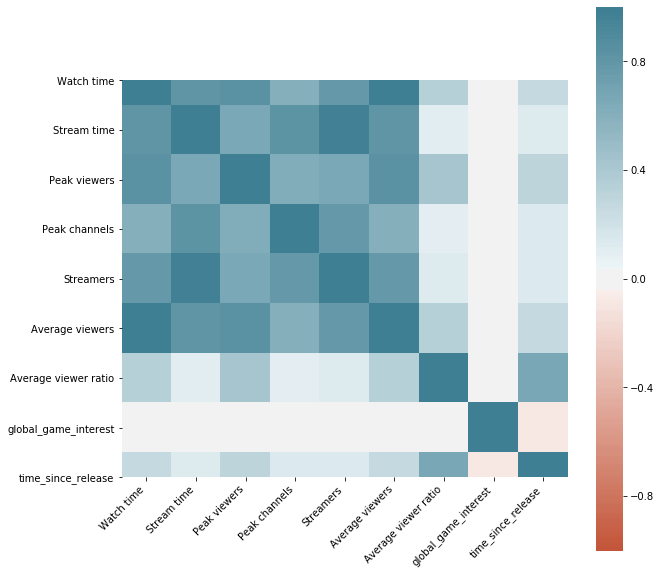

In [47]:
# don't forget to add boolean if the game was 
dirty_merged.loc[:,'time_since_release'] = dirty_merged.date.astype('int64') - dirty_merged.release_date.astype('int64')

corr = dirty_merged.loc[:,['google_search(relative)','Watch time','Stream time','Peak viewers',
                           'Peak channels','Streamers','Average viewers','Average viewer ratio',
                           'global_game_interest','time_since_release']].corr()

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(corr,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right')

In [37]:
len(np.unique(dirty_merged.critic_score))

59

In [48]:
dirty_merged.global_game_interest.dtype

dtype('int64')

In [74]:
dirty_merged.groupby('Game').count().index.value_counts()

The Evil Within 2              1
Remnant: From the Ashes        1
Mafia III                      1
Planet Coaster                 1
Mortal Kombat 11               1
                              ..
A Way Out                      1
The Elder Scrolls: Legends     1
Warhammer: Vermintide 2        1
Hyper Scape                    1
Sid Meier's Civilization VI    1
Name: Game, Length: 133, dtype: int64

In [49]:
dirty_merged.to_csv('blah.csv')

In [64]:
sb4r = dirty_merged.loc[(dirty_merged.date < dirty_merged.release_date),'stream_b4_release'].groupby('Game').mean().sort_values('Watch time',ascending=False)
rb4s = dirty_merged.loc[(dirty_merged.date > dirty_merged.release_date)].groupby('Game').mean().sort_values('Watch time',ascending=False)

In [65]:
dirty_merged.loc[(dirty_merged.date < dirty_merged.release_date),'stream_b4_release'] = 1
dirty_merged.loc[(dirty_merged.date > dirty_merged.release_date),'stream_b4_release'] = 0

Text(0.5, 0.98, 'Average Watchtime Before + After Beta')

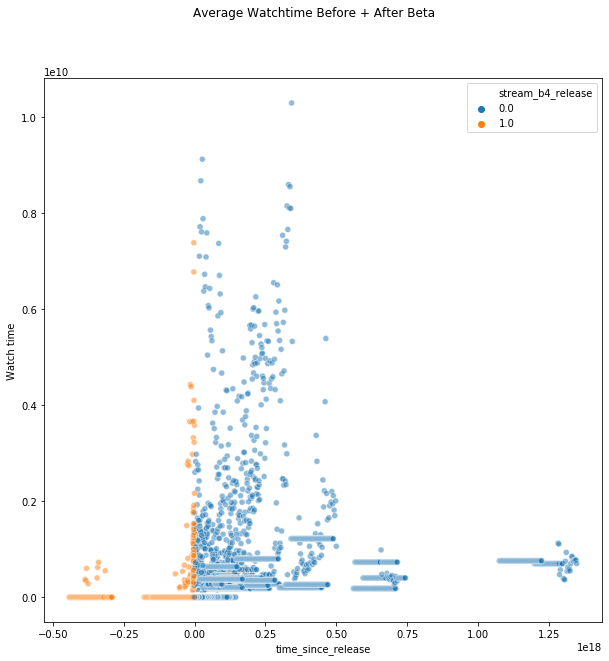

In [71]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.scatterplot(x='time_since_release',y='Watch time',hue='stream_b4_release',data=dirty_merged,alpha=0.5,)
fig.suptitle('Average Watchtime Before + After Beta')